# 스티커 프로젝트

In [254]:
# import library
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import os

## 이미지 불러오기

In [267]:
image_dir_path = "/aiffel/aiffel/camera_sticker/images"
cat_beard_path = "cat's beard.png"
eren_img_path = "eren.png"

cat = os.path.join(image_dir_path, cat_beard_path)
eren = os.path.join(image_dir_path, eren_img_path)

cat_img = cv2.imread(cat, cv2.IMREAD_UNCHANGED)
eren_img = cv2.imread(eren, cv2.IMREAD_COLOR)
eren_img_rgb = cv2.cvtColor(eren_img, cv2.COLOR_BGR2RGB)

print(cat_img.shape)
print(eren_img.shape)

(512, 512, 4)
(512, 512, 3)


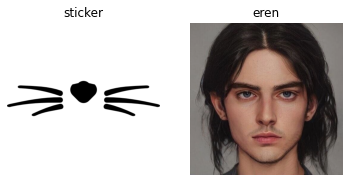

In [268]:
# 이미지 확인

plt.subplot(121)
plt.imshow(cat_img)
plt.title("sticker")
plt.axis("off")

plt.subplot(122)
plt.imshow(eren_img_rgb)
plt.title("eren")
plt.axis("off")
plt.show()

(512, 512, 3)


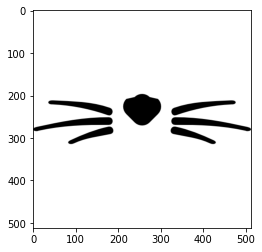

In [269]:
# 고양이 이미지 채널 변환

# 채널 분리
b, g, r, a = cv2.split(cat_img)

# 알파 채널 반전
a = cv2.bitwise_not(a)

# 알파 채널 값을 RGB 채널에 복사
r_channel = a.copy()
g_channel = a.copy()
b_channel = a.copy()

# RGB 이미지 생성
cat_img = cv2.merge((b_channel, g_channel, r_channel))
cat_img_rgb = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)

print(cat_img_rgb.shape)
plt.imshow(cat_img_rgb)
plt.show()

## Face bbox

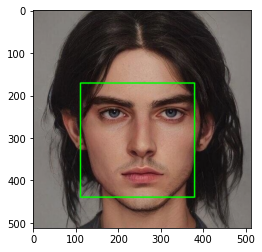

Bounding Boxes: rectangles[[(111, 171) (379, 439)]]


In [270]:
class FaceDetector(): # Face 감지 클래스
    
    def __init__(self): # HOG 디텍터 선언
        self._detector = dlib.get_frontal_face_detector() 
        
    def __call__(self, img, render=False):
        img_copy = img.copy()
        rects = self._detector(img_copy, 1) # face bbox 추출
        if render:
            self._render(img_copy, rects)
        print(f"Bounding Boxes: {rects}")
        return rects
    
    def _render(self, img, rects): # 렌더링
        
        color = 0, 255, 0
        thickness = 2
        lineType = cv2.LINE_AA
        
        for rect in rects:
            
            cv2.rectangle(img, 
                          (rect.left(), rect.top()),
                          (rect.right(), rect.bottom()),
                          color=color, 
                          thickness=thickness, 
                          lineType=lineType)
        plt.imshow(img)
        plt.show()

face_detector = FaceDetector()
rects = face_detector(eren_img_rgb, True)

### ibug 300w pretrained model load

In [271]:
from dlib import shape_predictor

class LandmarkGenerator(): # 랜드마크 생성 클래스
    
    def __init__(self, model_path): # 랜드마크 모델 가중치 로드
        self.model_path = model_path
        self._predictor = shape_predictor(model_path)
        
    def __call__(self, img, rects, render=False): # face 랜드마크 추출
        img_copy = img.copy()
        list_landmarks = []
        for rect in rects:
            points = self._predictor(img_copy, rect)
            list_points = self._point2xy(points)
            list_landmarks.append(list_points)
        print(f"generated landmarks({len(list_landmarks)},{len(list_landmarks[0])})")
        if render:
            self._render(img_copy, list_randmarks)
        return list_randmarks

    def _point2xy(self, points):
        return list(map(lambda p: (p.x, p.y), points.parts()))
    
    def _render(self, img, list_landmarks):
        
        color = 0,255,255
        radius = 2
        thickness = -1
        
        for landmark in list_landmarks:
            for point in landmark:
                cv2.circle(img, point, 
                           color=color, 
                           radius=radius, 
                           thickness=thickness)
        plt.imshow(img)
        plt.show()

generated landmarks(1,68)


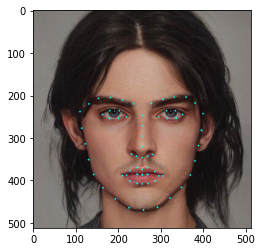

In [272]:
model_path = "/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat"
landmark_gen = LandmarkGenerator(model_path)
list_landmarks = landmark_gen(eren_img_rgb, dlib_rects, render=True)

###  스티커 적용

In [298]:
class StickerImageApplicator(): # 스티커 이미지 붙이는 클래스
        
    def __call__(self, face_img, sticker_img, w_ratio, h_ratio, render=False):
        
        face_img_copy = face_img.copy()
        sticker_img_copy = sticker_img.copy()
    
        # point 지정 및 위치 설정
        for rect, landmark in zip(rects, list_landmarks): # 
            x = landmark[30][0]
            y = landmark[30][1] - rect.height() // 2
            w = h = rect.width()
            
        img_sticker = cv2.resize(sticker_img_copy, (w,h))
        
        refined_x = x - w // w_ratio
        refined_y = y + h // h_ratio
        
        # 영역을 벗어나는 부분 처리 (refined_y)
        if refined_x < 0:
            img_sticker = img_sticker[:, -refined_x:]
            refined_x = 0
        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0
        
        # 원본 이미지에 스티커 이미지 적용
        sticker_area_y = slice(refined_y, refined_y+img_sticker.shape[0])
        sticker_area_x = slice(refined_x, refined_x+img_sticker.shape[1])
        sticker_area = face_img_copy[sticker_area_y, sticker_area_x]
        
        fill_empty_area = np.where(img_sticker==255, sticker_area, img_sticker)
        face_img_copy[sticker_area_y, sticker_area_x] = fill_empty_area
        
        if render:
            self._render(face_img_copy)
        
    def _render(self, image):
        plt.imshow(image)
        plt.show()

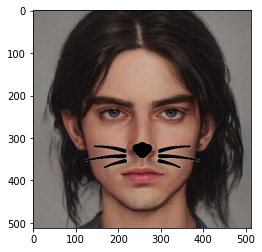

In [299]:
applicator = StickerImageApplicator()
applicator(eren_img_rgb, cat_img_rgb, 
           w_ratio=2, h_ratio=14, render=True)

## 문제점
* 사진이 회전하거나 밝기, 거리에 따라 face detection이 제대로 되지 않거나 이미지를 적용하기 어려운 문제가 있다.
* 사진이 왜곡 되거나 회전하는 경우에는 적용해야하는 이미지도 그에 맞춰 변환해줘야 한다.
* 밝기가 너무 밝거나 어두운 경우 face detection이 제대로 되지 않을 수 있다.
* 촬영 거리에 따라 face detection이 수행된 결과의 비율로 이미지도 동일하게 맞춰줘야 한다.
* 각도에 따라서 2D 이미지를 3D 투영해야하는 경우도 있을 수 있다.

# 회고
* 이미지 처리에 대해 특히 Face detection에 대해 학습할 수 있었다.
* 이미지 데이터에 고려해야할 내용이 정말 많다는 것을 느꼈다.
* 교육 시간내에 많은 것을 해보지 못해 아쉬웠다. 이미지 태스크에 대해 더 많은 실습을 해봐야겠다.
* 이미지 구성 특성에 따른 처리가 어려웠다. 여러 구성에 대해 자세히 알아봐야겠다.